In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import glob
import functools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

import pandas as pd
from PIL import Image

import tensorflow as tf
print(tf.__version__)
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import models
!pip install SimpleITK
import SimpleITK as sitk 

1.13.1


In [3]:
%load_ext autoreload
%autoreload 2
%cd '/content/gdrive/My Drive/DeepLearning/2DUnet-git'

/content/gdrive/My Drive/DeepLearning/2DUnet-git


In [0]:
from utils import getTrainNLabelNames
from prediction import data_preprocess_intensity, data_preprocess_scale, data_preprocess_intensity_2scale

In [5]:
modality = ["ct", "mr"]
data_folder = '/content/gdrive/My Drive/ImageData/MMWHS'
x_train_filenames_ct, y_train_filenames_ct = getTrainNLabelNames(data_folder, modality[0])
print("Number of training volumes %d" % len(x_train_filenames_ct))
print("Number of mask volumes %d" % len(y_train_filenames_ct))
x_train_filenames_mr, y_train_filenames_mr = getTrainNLabelNames(data_folder, modality[1])
print("Number of training volumes %d" % len(x_train_filenames_mr))
print("Number of mask volumes %d" % len(y_train_filenames_mr))

Number of training volumes 20
Number of mask volumes 20
Number of training volumes 20
Number of mask volumes 20


In [6]:
from loss import bce_dice_loss, dice_loss
save_model_path_both = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs_2/MMWHS_small3/weights_multi-all-axial_small2.hdf5'
save_model_path_ct = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs_2/MMWHS_ct/weights_multi-all-axial_small2.hdf5'
save_model_path_mr = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs_2/MMWHS_mr/weights_multi-all-axial_small2.hdf5'
from model import UNet2D
img_shape = (256, 256, 1)
inputs, outputs = UNet2D(img_shape, 8)
unet = models.Model(inputs=[inputs], outputs=[outputs])
unet.load_weights(save_model_path_both)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
from skimage.transform import resize
def croppedImage(img_fn, mask_fn, m, view, size):
  img_vol, _, _ = data_preprocess_intensity_2scale(img_fn, m)
  print(img_vol.shape)
  img_vol = data_preprocess_scale(img_vol, view, 256)
  msk = sitk.ReadImage(mask_fn)
  print(msk.GetSpacing())
  print(msk.GetOrigin())
  print(msk.GetDirection())
  maskVol = sitk.GetArrayFromImage(msk).astype(float)
  space = msk.GetSpacing()
  maskshape = maskVol.shape
  maskVol = resize(maskVol, (space[0]*maskshape[0],space[1]*maskshape[1], space[2]*maskshape[2])) 
  if m == "mr":
    maskVol = np.moveaxis(maskVol, 0, -1)
    
  maskVol = np.moveaxis(maskVol, view, 0)
  IDs = np.max(np.max(maskVol,axis=-1),axis=-1)==0
  sliced = np.moveaxis(img_vol,view,0)[~IDs,:,:]
  sliced = np.moveaxis(resize(sliced, (size,256,256), order=1), 0, view)
  mask_sliced = np.moveaxis(maskVol,view,0)[~IDs,:,:]
  mask_sliced = np.moveaxis(resize(mask_sliced, (size,256,256), order=1), 0, view)
  
  return sliced, mask_sliced

In [0]:
def getLayerIndexByName(model, layernames):
    ids = []
    for idx, layer in enumerate(model.layers):
        print(layer.name)
        if layer.name in layernames:
            ids.append(idx)
    return ids

In [0]:
from tensorflow.python.keras import backend as K

In [10]:
#ids = getLayerIndexByName(unet, ["max_pooling2d", "max_pooling2d_1", "max_pooling2d_2","max_pooling2d_3", "max_pooling2d_4"])
ids = getLayerIndexByName(unet, ["conv2d_22"])
print(ids)
get_all_layer_outputs = K.function([unet.layers[0].input],
                                  [unet.layers[i].output for i in ids])

input_1
conv2d
batch_normalization_v1
activation
conv2d_1
batch_normalization_v1_1
activation_1
max_pooling2d
conv2d_2
batch_normalization_v1_2
activation_2
conv2d_3
batch_normalization_v1_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_v1_4
activation_4
conv2d_5
batch_normalization_v1_5
activation_5
max_pooling2d_2
conv2d_6
batch_normalization_v1_6
activation_6
conv2d_7
batch_normalization_v1_7
activation_7
max_pooling2d_3
conv2d_8
batch_normalization_v1_8
activation_8
conv2d_9
batch_normalization_v1_9
activation_9
max_pooling2d_4
conv2d_10
batch_normalization_v1_10
activation_10
conv2d_11
batch_normalization_v1_11
activation_11
conv2d_transpose
concatenate
batch_normalization_v1_12
activation_12
conv2d_12
batch_normalization_v1_13
activation_13
conv2d_13
batch_normalization_v1_14
activation_14
conv2d_transpose_1
concatenate_1
batch_normalization_v1_15
activation_15
conv2d_14
batch_normalization_v1_16
activation_16
conv2d_15
batch_normalization_v1_17
activation_17
conv2d_t

In [0]:
num = 10
outputs_ct = []
for i in range(num):
  features = croppedImage(x_train_filenames_ct[i], y_train_filenames_ct[i], modality[0], 0, 40)
  print(features.shape)
  layer_output = get_all_layer_outputs([np.expand_dims(features, axis=-1)])
  print(layer_output[0].shape)
  outputs_ct.append(layer_output[0].flatten())
outputs_ct = np.array(outputs_ct)
print(outputs_ct.shape)
outputs_mr = []
for i in range(num):
  print(x_train_filenames_mr[i], y_train_filenames_mr[i])
  features = croppedImage(x_train_filenames_mr[i], y_train_filenames_mr[i], modality[1], 0, 40)
  print(features.shape)
  layer_output = get_all_layer_outputs([np.expand_dims(features, axis=-1)])
  print(layer_output[0].shape)
  outputs_mr.append(layer_output[0].flatten())
outputs_mr = np.array(outputs_mr)
print(outputs_mr.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(40, 256, 256)
(40, 256, 256, 8)
(10, 20971520)
/content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1001_image.nii.gz /content/gdrive/My Drive/ImageData/MMWHS/mr_train_masks/mr_train_1001_label.nii.gz
(40, 256, 256)
(40, 256, 256, 8)
/content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1002_image.nii.gz /content/gdrive/My Drive/ImageData/MMWHS/mr_train_masks/mr_train_1002_label.nii.gz
(40, 256, 256)
(40, 256, 256, 8)
/content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1003_image.nii.gz /content/gdrive/My Drive/ImageData/MMWHS/mr_train_masks/mr_train_1003_label.nii.gz
(40, 256, 256)
(40, 256, 256, 8)
/content/gdrive/My Drive/ImageData/MMWHS/mr_train/mr_train_1004_image.nii.gz

In [26]:
# mask 
num = 1
outputs_ct = []
for i in range(num):
  _, features_ct = croppedImage(x_train_filenames_ct[i], y_train_filenames_ct[i], modality[0], 0, 50)
  print(features_ct.shape)
  outputs_ct.append(features_ct.flatten())
outputs_ct = np.array(outputs_ct)
print(outputs_ct.shape)
outputs_mr = []
for i in range(num):
  _, features_mr = croppedImage(x_train_filenames_mr[i], y_train_filenames_mr[i], modality[1], 0, 50)
  print(features_mr.shape)
  outputs_mr.append(features_mr.flatten())
outputs_mr = np.array(outputs_mr)
print(outputs_mr.shape)

(130, 182, 231)
(0.35546875, 0.35546875, 0.44999998807907104)
(-45.5, 228.58453369140625, -271.8800048828125)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(50, 256, 256)
(1, 3276800)
(400, 820, 125)
(0.78125, 0.78125, 1.600000023841858)
(-206.0869598388672, -155.02609252929688, -199.21875)
(1.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, 1.0, -0.0)
(50, 256, 256)
(1, 3276800)


In [0]:
# resample images to have resolution 0.5*0.5*0.5
def resample(sitkIm_fn, resolution = (0.5, 0.5, 0.5), dim=3):
  image = sitk.ReadImage(sitkIm_fn)
  resample = sitk.ResampleImageFilter()
  resample.SetInterpolator(sitk.sitkLinear)
  resample.SetOutputDirection(image.GetDirection())
  resample.SetOutputOrigin(image.GetOrigin())
  resample.SetOutputSpacing(resolution)

  orig_size = np.array(image.GetSize(), dtype=np.int)
  orig_spacing = np.array(image.GetSpacing())
  new_size = orig_size*(orig_spacing/np.array(resolution))
  new_size = np.ceil(new_size).astype(np.int) #  Image dimensions are in integers
  new_size = [int(s) for s in new_size]
  resample.SetSize(new_size)
  newimage = resample.Execute(image)
  
  return newimage

In [0]:
def HistogramEqualization(pyIm):
    pyImNew = np.empty(pyIm.shape)

    num = int(np.max(pyIm.flatten())-np.min(pyIm.flatten()))+1
    im_hist, bins = np.histogram(pyIm.flatten(), num)

    cdf = im_hist.cumsum()
    cdf = max(pyIm.flatten()) * cdf /cdf[-1]

    image_equalized = np.interp(pyIm.flatten(),bins[:-1],cdf)
    pyImNew = np.reshape(image_equalized,pyIm.shape)
    
    return pyImNew

(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0) (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(327, 364, 364) (327, 364, 364)
3044.8586 -1024.0
850 0
3044.858642578125 628.9689665425954


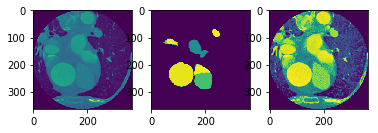

In [14]:
# mask 
num = 1
outputs_ct = []
for i in range(num):
  im = resample(x_train_filenames_ct[i])
  im_mask = resample(y_train_filenames_ct[i])
  print(im.GetDirection(), im_mask.GetDirection())
  im = sitk.GetArrayFromImage(im)
  im_mask = sitk.GetArrayFromImage(im_mask)
  print(im.shape, im_mask.shape)
  plt.figure()
  plt.subplot(1,3,1)
  print(np.max(im), np.min(im))
  print(np.max(im_mask), np.min(im_mask))
  plt.imshow(im[250,:,:])
  plt.subplot(1,3,2)
  plt.imshow(im_mask[250,:,:])
  plt.subplot(1,3,3)
  histEq_im = HistogramEqualization(im)
  print(np.max(histEq_im), np.min(histEq_im))
  plt.imshow(histEq_im[250,:,:])
  plt.show()

850.0000000000008 0.0
850.0 0.0


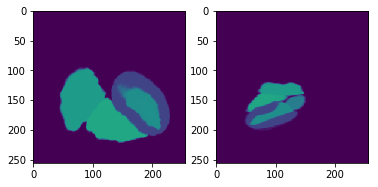

In [27]:
plt.figure()
plt.subplot(1,2,1)
print(np.max(features_ct), np.min(features_ct))
print(np.max(features_mr), np.min(features_mr))
plt.imshow(features_ct[10,:,:], vmax=1000,vmin=0)
plt.subplot(1,2,2)
plt.imshow(features_mr[10,:,:], vmax=1000,vmin=0)
plt.show()

In [0]:
from matplotlib import offsetbox
def plot_embedding(X, y, title=None):
    classes = ["ct", "mr"]
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(len(np.unique(y))):
      X_c = X[y==i,:]
      plt.scatter(X_c[:,0], X_c[:,1],color=plt.cm.tab10(i/ 10.), label=classes[i] )

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing t-SNE embedding


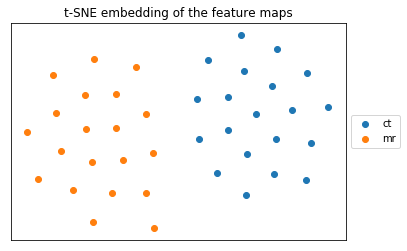

In [0]:
from sklearn import manifold
#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.concatenate((outputs_ct, outputs_mr)))

plot_embedding(X_tsne, np.array([np.zeros(num), np.ones(num)]).flatten(),
               "t-SNE embedding of the feature maps")

plt.show()